# Prepration
## Imports

In [1]:
import sys
from pathlib import Path

import pandas as pd
from pdf2image import pdf2image

# import hbsir

# The following code is written to import hbsir library from this
# repository without installation. Usually, you can import the library
# by writing "import hbsir"

for parent in Path().absolute().parents:
    if len(list(parent.glob("hbsir"))) > 0:
        hbsir_path = parent
        break
else:
    raise FileNotFoundError
sys.path.append(str(hbsir_path))

import hbsir

## Open The Report

In [2]:
try:
    with open("summary-results.pdf", mode="rb") as pdf_file:
        pdf_content = pdf_file.read()
except FileNotFoundError:
    import requests

    url = r"https://amar.org.ir/Portals/0/News/1402/hazineh%20daramad1401.pdf?ver=dqdR7ojDLzIyd13v3Xs7RA%3d%3d"
    report_file = requests.get(url)
    pdf_content = report_file.content
    with open("summary-results.pdf", mode="wb") as pdf_file:
        pdf_file.write(pdf_content)
report_pages = pdf2image.convert_from_bytes(pdf_content, dpi=100)

In [3]:
YEAR = 1401

# Household Income and Expenditure at a Glance
## Table 1
The total annual net and gross expenditures of urban and rural households on food, tobacco, and non-food items for the years 1400 and 1401.

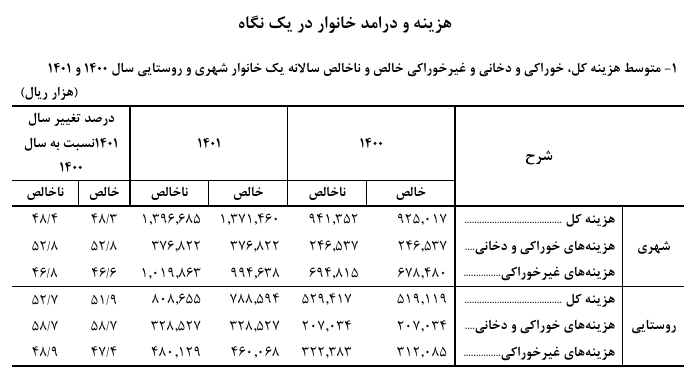

In [4]:
expenditure_summery_table = report_pages[4].crop((55, 130, 750, 520))

image_size = expenditure_summery_table.size
scale = 0.85
new_size = tuple(int(num * scale) for num in image_size)
final_image = expenditure_summery_table.resize(new_size)

expenditure_summery_table

In [5]:
def sort_key(axis: pd.Index):
    sort_order = {
        "Total": 1,
        "Food": 2,
        "Non-Food": 3,
        "Urban": 11,
        "Rural": 12,
        "Net": 21,
        "Gross": 22,
        1400: 31,
        1401: 32,
        "Percentage_Change": 33,
    }
    axis = axis.map(sort_order)
    axis = axis.astype(int)
    return axis

(
    hbsir.load_table("Expenditures", [YEAR-1, YEAR])
    .pipe(hbsir.add_classification, "Food-NonFood")
    .groupby(["Year", "ID", "Food-NonFood"])[["Gross_Expenditure", "Net_Expenditure"]].sum()
    .rename({"Gross_Expenditure": "Gross", "Net_Expenditure": "Net"}, axis="columns")
    .unstack()
    .pipe(lambda df: df.set_axis(df.columns.to_flat_index(), axis="columns"))
    .pipe(hbsir.add_weight)
    .pipe(
        lambda df: df.apply(lambda s: s.mul(df["Weight"]) if s.name != "Weight" else s)
    )
    .pipe(hbsir.add_attribute, "Urban_Rural")
    .groupby(["Year", "Urban_Rural"]).sum()
    .pipe(
        lambda df: df.apply(lambda s: s.div(df["Weight"]) if s.name != "Weight" else s)
    )
    .drop(columns="Weight")
    .pipe(
        lambda df: df.set_axis(
            pd.MultiIndex.from_tuples(df.columns, names=["Net-Gross", "Food-NonFood"]),
            axis="columns",
        )
    )
    .stack(0)
    .eval("Total = Food + `Non-Food`")
    .stack()

    .div(1000)
    .unstack("Year")
    .assign(Percentage_Change=lambda df: (df[YEAR] / df[YEAR-1] - 1) * 100)
    .unstack("Net-Gross")
    .sort_index(key=sort_key)
    .sort_index(key=sort_key, axis="columns")
    .style.format("{:,.0f}", subset=[YEAR-1, YEAR])
    .format("{:,.1f}", subset=["Percentage_Change"])
)

## Table 2
The annual income of urban and rural households for the years 1399 and 1400.

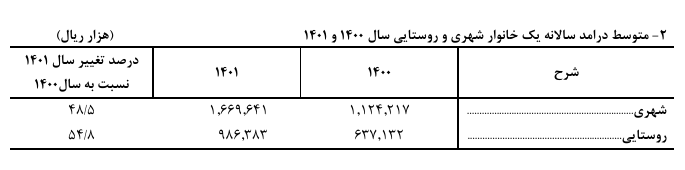

In [6]:
income_summery_table = report_pages[4].crop((45, 520, 730, 690))

image_size = income_summery_table.size
scale = 0.8
new_size = tuple(int(num * scale) for num in image_size)
final_image = income_summery_table.resize(new_size)
income_summery_table

In [7]:
(
    hbsir.load_table("Total_Income", years=[YEAR-1, YEAR])
    .pipe(hbsir.add_attribute, "Urban_Rural")
    .pipe(hbsir.add_weight)
    .assign(Weighted_Income=lambda t: t.eval("Income * Weight"))
    .groupby(["Year", "Urban_Rural"])[["Weighted_Income", "Weight"]].sum()
    .assign(Weighted_Income=lambda t: t.eval("Weighted_Income / Weight"))
    .loc[:, ["Weighted_Income"]]
    .div(1000)
    .unstack(0)
    .droplevel(0, axis="columns")
    .sort_index(ascending=False)
    .assign(Percentage_Change=lambda t: (t[YEAR] / t[YEAR-1] * 100) - 100)
    .style.format("{:,.0f}", subset=[YEAR-1, YEAR])
    .format("{:,.1f}", subset=["Percentage_Change"])
)

Year,1400,1401,Percentage_Change
Urban_Rural,,,
Urban,"1,124,214","1,670,203",48.6
Rural,"637,147","991,082",55.5


## Table 4

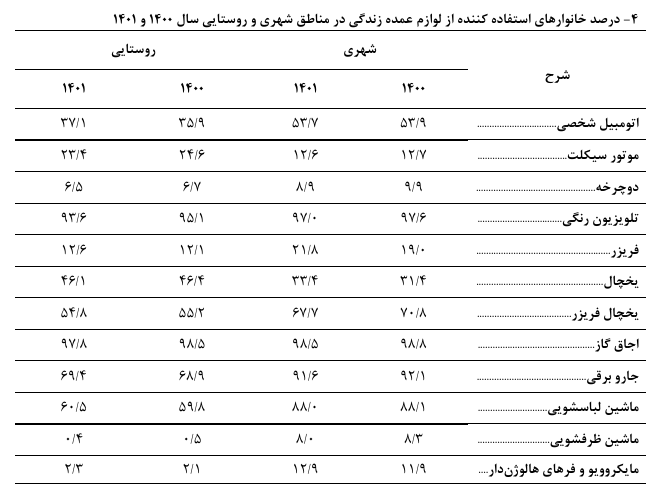

In [8]:
income_summery_table = report_pages[5].crop((100, 150, 750, 650))

image_size = income_summery_table.size
scale = 0.8
new_size = tuple(int(num * scale) for num in image_size)
final_image = income_summery_table.resize(new_size)
income_summery_table

In [9]:
items = [
    "Car",
    "Motorcycle",
    "Bicycle",
    "TV_CR",
    "Freezer",
    "Refrigerator",
    "Frizer_Refrigrator",
    "Oven",
    "Vaccum",
    "Washing_Machine",
    "Dishwasher",
    "Microwave_Oven",
]
(
    hbsir.load_table("house_specifications", years=[YEAR-1, YEAR])
    .pipe(hbsir.add_attribute, "Urban_Rural")
    .pipe(hbsir.add_weight)
    .astype({column: float for column in items})
    .eval("\n".join([f"{column} = {column} * Weight" for column in items]))
    .groupby(["Urban_Rural", "Year"])[items + ["Weight"]]
    .sum()
    .eval("\n".join([f"{column} = {column} / Weight * 100" for column in items]))
    .drop(columns="Weight")
    .T.sort_index(axis="columns", level="Year", sort_remaining=False)
    .sort_index(
        axis="columns", level="Urban_Rural", ascending=False, sort_remaining=False
    )
    .style.format("{:,.1f}")
)

## Table 5

### Table image

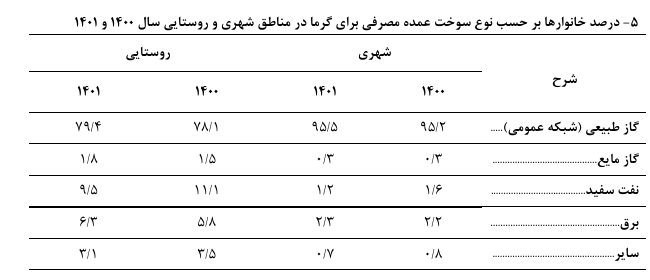

In [10]:
income_summery_table = report_pages[5].crop((100, 670, 750, 950))

image_size = income_summery_table.size
scale = 0.8
new_size = tuple(int(num * scale) for num in image_size)
final_image = income_summery_table.resize(new_size)
income_summery_table

### Simple Replication

In [11]:
df = hbsir.load_table("house_specifications", years=[YEAR-1, YEAR])
df = hbsir.add_attribute(df, "Urban_Rural")
df = hbsir.add_weight(df)
filt = df["Heating_Fuel"].isin(["None", "Wood_and_Charcoal", "Gasoline", "Animal_Fuel", "Other_Fuel"])
df.loc[filt, "Heating_Fuel"] = "Other_Fuels"
df = df.groupby(["Year", "Urban_Rural", "Heating_Fuel"])[["Weight"]].sum()
df = df.join(df.groupby(["Year", "Urban_Rural"])["Weight"].transform("sum").rename("Weight_Sum"))
df = (df["Weight"] / df["Weight_Sum"] * 100).to_frame()
df = pd.pivot(df.reset_index(), index=["Heating_Fuel"], columns=["Urban_Rural", "Year"])
df = df.droplevel(0, axis="columns")
df = df.loc[
    ["Piped_Gas", "Liquid_Gas", "Karosine", "Electricity", "Other_Fuels"],
    [("Urban", 1400), ("Urban", 1401), ("Rural", 1400), ("Rural", 1401)]
]
df.style.format("{:,.1f}")

### Data Pipeline

In [12]:
(
    hbsir.load_table("house_specifications", years=[YEAR-1, YEAR])
    .pipe(hbsir.add_attribute, "Urban_Rural")
    .pipe(hbsir.add_weight)
    .assign(
        Heating_Fuel=lambda df: df["Heating_Fuel"]
        .where(
            lambda s: s.isin(["Piped_Gas", "Liquid_Gas", "Karosine", "Electricity"]),
            "Other_Fules"
        )
    )
    .groupby(["Year", "Urban_Rural", "Heating_Fuel"])[["Weight"]].sum()
    .unstack([1, 0])
    .pipe(lambda df: df / df.sum() * 100)
    .sort_index(
        axis="columns",
        key=lambda s: s.map({"Urban": 0, "Rural": 1, 1400: 0, 1401: 1})
    )
    .sort_index(
        key=lambda s: s.map(
            {
                "Piped_Gas": 0,
                "Liquid_Gas": 1,
                "Karosine": 2,
                "Electricity": 3,
                "Other_Fules": 4
            }
        )
    )
    .style.format("{:,.1f}")
)

## Table 6

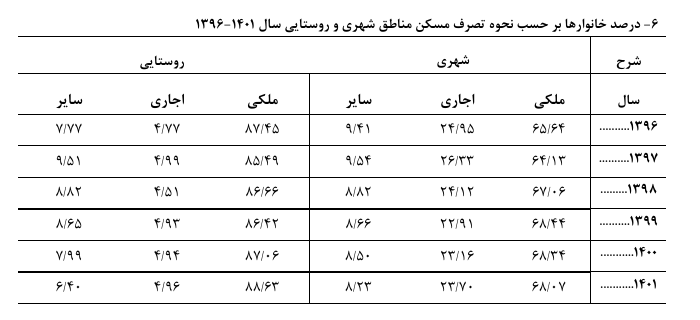

In [13]:
income_summery_table = report_pages[6].crop((80, 130, 780, 450))

image_size = income_summery_table.size
scale = 0.8
new_size = tuple(int(num * scale) for num in image_size)
final_image = income_summery_table.resize(new_size)
income_summery_table

In [14]:
(
    hbsir.load_table("house_specifications", years=f"{YEAR-5}-{YEAR}")
    .assign(Tenure=lambda df: df["Tenure"].map({
        "Owned_Estate_Land": "Owned",
        "Owned_Estate": "Owned",
        "Rent": "Rent",
        "Mortgage": "Rent",
        "Service": "Other",
        "Free": "Other",
        "Other": "Other",
    }))
    .pipe(hbsir.add_attribute, "Urban_Rural")
    .pipe(hbsir.add_weight)
    .groupby(["Year", "Urban_Rural", "Tenure"])[["Weight"]].sum()
    .unstack([0, 1])
    .droplevel(0, axis="columns")
    .pipe(lambda df: df / df.sum() * 100)
    .stack(0)
    .unstack(0)
    .sort_index(
        axis="columns",
        key=lambda s: s.map({"Urban": 0, "Rural": 1, "Owned": 0, "Rent": 1, "Other": 2})
    )
    .style.format("{:,.2f}")
)